<h1> Advanced Learning for Text and Graph Data </h1>
<b> Université Paris-Saclay - Master M2 Data Science - February/March 2017</b> <br>
<i> Students : Peter Martigny & Mehdi Miah </i> <br>

# Second part  : analyze the data

## Open the data

In [1]:
#import
import numpy as np
import pandas as pd
#import operator
#from collections import Counter
#from tqdm import *
from handy_structures import * #own functions
import matplotlib.pyplot as plt
%matplotlib inline

#path to data and results
path_to_data = "..\\data\\"
path_to_results = "..\\results\\"

#open files
#original data
training_set = pd.read_csv(path_to_data + 'training_set.csv')
training_info = pd.read_csv(path_to_data + 'training_info.csv', 
                            dtype = {'mid': object, 'date': object, 'body': object, 'recipients' : object})
test_set = pd.read_csv(path_to_data + 'test_set.csv')
test_info = pd.read_csv(path_to_data + 'test_info.csv',
                        dtype = {'mid': object, 'date': object, 'body': object, 'recipients' : object})

#dataframe with all data
training_df = pd.read_csv(path_to_results + 'training_df.csv',
                          dtype = {'mid': object, 'sender': object, 'date': object, 'body': object, 'recipients' : object})
test_df = pd.read_csv(path_to_results + 'test_df.csv',
                          dtype = {'mid': object, 'sender': object, 'date': object, 'body': object})

## Dimensions of the problems

### Number of emails

In [2]:
# Training set
n_mails_training = training_df.shape[0]
print('There are', n_mails_training, 'different emails in the training dataset.')

# Test set
n_mails_test = test_df.shape[0]
print('There are', n_mails_test, 'different emails in the test dataset.')

There are 43613 different emails in the training dataset.
There are 2362 different emails in the test dataset.


### Number of unique senders

In [3]:
# Training set
n_senders_training = len(training_df['sender'].unique())
print('There are', n_senders_training, 'different senders in the training dataset.')

# Test set
n_senders_test = len(test_df['sender'].unique())
print('There are', n_senders_test, 'different senders in the test dataset.')

There are 125 different senders in the training dataset.
There are 125 different senders in the test dataset.


Fortunately, every sender in the test dataset is in the train dataset.

### Number of unique recipients

In [4]:
#Training set
list_recipients = []

for row in range(training_df.shape[0]):
    list_recipients.extend(training_df['recipients'][row].split(' '))
    
n_recipients_training = len(np.unique(list_recipients))
print('There are', n_recipients_training, 'different recipients in the training dataset.')

#Test set
# we have to find them =)

There are 9871 different recipients in the training dataset.


We can notice than there are 80 times more recipients than senders ! 

## Distribution of number of mails sent by individual

In [5]:
if False: 
    def get_address_books(dataset_info, dataset_set):
        '''
        Computes address book with frequency information for each user
        '''
        address_books = {} #a new dictionnary
        emails_ids_per_sender = get_mids_per_sender(dataset_set)

        for sender, ids in tqdm(emails_ids_per_sender.items()): #for key and value of the dictionnary
            recs_temp = [] #will contain the recipients
            for my_id in ids: #for each mail
                recipients = dataset_info[dataset_info['mid'] == my_id]['recipients'].tolist() #list of all the recipients
                recipients = recipients[0].split(' ') #get a list of all the recipients
                # keep only legitimate email addresses
                recipients = [rec for rec in recipients if '@' in rec]
                recs_temp.append(recipients)
            # flatten    
            recs_temp = [elt for sublist in recs_temp for elt in sublist] #one list
            # compute recipient counts
            rec_occ = dict(Counter(recs_temp)) #we count the times the sender sent a mail to someone
            # order by frequency
            sorted_rec_occ = sorted(rec_occ.items(), key=operator.itemgetter(1), reverse = True)
            # save
            address_books[sender] = sorted_rec_occ

        return address_books

In [6]:
address_books = get_address_books(training_info, training_set)

In [7]:
n_emails_per_sender_training = {} #create a new dictionnary
for index, series in training_set.iterrows(): #series contains senders and mids
    #for each instance:
    row = series.tolist() #we get a list of with the sender at position 0 and each of ones mails
    sender = row[0] #this is the sender
    ids = row[1:][0].split(' ') #we get a list with all the mids
    n_emails_per_sender_training[sender] = len(ids) #we add them in the dictionnary
    
#We sort it in order to make the plot easier later    
n_emails_per_sender_training = sorted(n_emails_per_sender_training.values())

In [8]:
# Sanity test
np.sum(n_emails_per_sender_training) == training_info.shape[0]

True

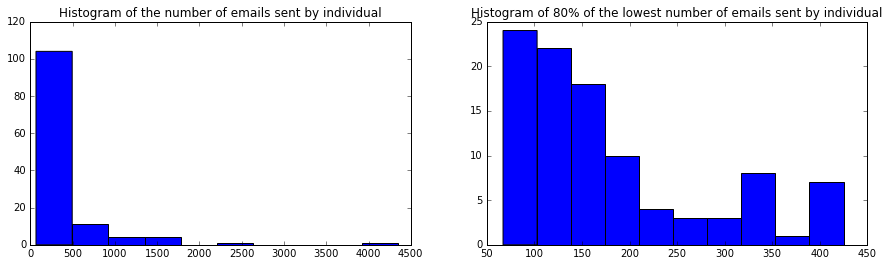

In [9]:
plt.figure(figsize=(15.0, 4.0))

plt.subplot(1, 2, 1)
plt.hist(n_emails_per_sender_training)
plt.title('Histogram of the number of emails sent by individual')

plt.subplot(1, 2, 2)
plt.hist(n_emails_per_sender_training[:round(0.8*n_senders_training)])
plt.title('Histogram of 80% of the lowest number of emails sent by individual')


In [10]:
#Some statistics on that distribution

mean_n_emails_per_sender_training = np.mean(n_emails_per_sender_training)
print('The mean of this distribution is', mean_n_emails_per_sender_training)

median_n_emails_per_sender_training = np.median(n_emails_per_sender_training)
print('The median of this distribution is', median_n_emails_per_sender_training)


The mean of this distribution is 348.904
The median of this distribution is 168.0


So, this a positive skewed distribution.

## How many times do they send an email to someone ?

In [11]:
#Count the number of mails sent to an employe
n_mails_sent_to_someone=[]
for sender, value in address_books.items(): #for each sender
    for rec in value: #for each recipient
        res = rec[1] #the number of email sent by 'sender' to 'rec'
        n_mails_sent_to_someone.append(res)  
        
# We sort the result in order to make the analysis easier        
n_mails_sent_to_someone = sorted(n_mails_sent_to_someone)

In [12]:
#Number of unique links sender-recipient
len(n_mails_sent_to_someone)

23134

In [13]:
# Count the percentage of links sender-recipient with one mail related to them.
# A '1' means that it exist a couple (sender, recipient) such that the sender sent only one mail to the recipient.
n_links_with_one_mail = n_mails_sent_to_someone.count(1)/len(n_mails_sent_to_someone)
print('%.1f%% of the links are made with only one mail.' % round(n_links_with_one_mail * 100, 1))

33.6% of the links are made with only one mail.


This simple statics is rude : one third of the connection is unique. Consequently, if we based the prediction on the previous recipient for a user, we will miss, at least one case over three, a recipient.

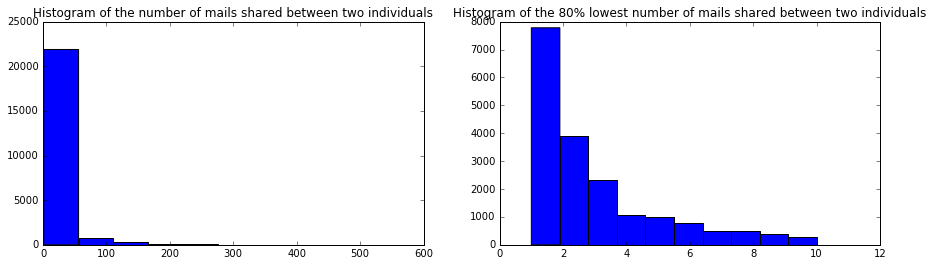

In [14]:
plt.figure(figsize=(15.0, 4.0))

plt.subplot(1, 2, 1)
plt.hist(n_mails_sent_to_someone)
plt.title('Histogram of the number of mails shared between two individuals')

plt.subplot(1, 2, 2)
limit = round(0.8*len(n_mails_sent_to_someone))
plt.hist(n_mails_sent_to_someone[:limit])
plt.title('Histogram of the 80% lowest number of mails shared between two individuals')

## Relation with power of a link and number of recipients

In [15]:
def get_power_link(sender, recipient):
    adress_books_sender = address_books[sender]
    for rec, link in adress_books_sender:
        if rec == recipient:
            return link

In [16]:
#mat_nrec_power = pd.DataFrame()

#for row in tqdm(range(training_df.shape[0])): #for each mail
#    sender = training_df['sender'][row]  
#    recipients = training_df['recipients'][row].split(' ')
#    n_recipients = len(recipients)
#    for rec in recipients:
#        temp = pd.DataFrame({'nrec':[n_recipients], 'power':[get_power_link(sender, rec)]})
#        mat_nrec_power = mat_nrec_power.append(temp)

In [17]:
#plt.scatter(mat_nrec_power['power'], mat_nrec_power['nrec'])
#plt.title("Number of recipients per mail and power of a link")

## Analysis of date

In [18]:
#TODO
# date comme facteur de séparation entre training et test
date_training = pd.DataFrame()
date_training['date'] = training_df['date'] 
date_training['origin'] = 'train'

date_test = pd.DataFrame()
date_test['date'] = test_df['date']
date_test['origin'] = 'test'

all_date =  pd.concat([date_training, date_test])

all_date.to_csv(path_to_results + 'all_date.csv', index = False)

We notice some dirty dates (year 0001).

## Self email

In [19]:
#TODO
# How many mails sent to oneself ?

They do exist !